# Задача
одна из проблем, которую мы видим при обращении в саппорт - в разрезе разных категорий обращения необходимо смотреть в разные сервисы и собирать дополнительную информацию. На это уходит много времени. на одно обращение уходит в среднем 2 минуты поиска дополнительной информации. Стоимость часа работы сотрудника 6$.

Давайте поможем и оптимизируем время и деньги компании - сделаем модель,которая в зависимости от текста будет определять категорию обращения автоматически.

Тогда мы сможем сразу подготавливать информацию для наших операторов в течение 5 секунд (сбор и передача на фронт)

Нужно сделать модель многоклассовой классификации определения категории обращения

# загружаем данные

In [ ]:
!pip install sumy
!pip install stop_words
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
  

In [2]:

from sklearn.feature_extraction.text import TfidfVectorizer

import datetime
import requests
import collections as co
import string
import re

import nltk
from sumy.utils import get_stop_words as gsw1
from stop_words import get_stop_words as gsw2


import pandas as pd
import numpy as np

In [3]:

from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
df = pd.read_csv('/content/drive/My Drive/Xsolla/nets/data/3categories_50.csv')
df.shape

(50000, 3)

# прежде всего очистка данных

In [7]:
#убираем технические данные в сообщениях и прочий шум
df['message'] = df['message'].str.replace('\[.*\]', '', regex=True)

df['message'] = df['message'].str.replace("\!", '', regex=True)
df['message'] = df['message'].str.replace("\'", '', regex=True)

df['message'] = df['message'].str.replace("[^A-Za-z0-9^,!.\/'+-=]", ' ', regex=True)


In [8]:
#переведем в нижний регистр
df['message'] = df['message'].str.replace("\s+", ' ', regex=True)
df['message'] = df['message'].str.lower()

In [9]:
#уберем шум
df.dropna(inplace = True)
df.shape

(49999, 3)

In [10]:
# уберем шумовые длинные сообщения
df['message_len'] = df['message'].str.len()

df = df[(df['message_len'] < np.percentile(df.message_len,99))][:]

df.shape

(49499, 4)

# очистим весь наш текст от шумовых слов и преобразуем к первообразным формам


In [11]:
list_count_words = []
list_true_words = []
list_tagged = []
list_tags = []

for row in  df.message:
    words = []
    tagged = []
    true_words = []
    tags = []
    
    a_line = row

    
    try:
        words = re.split(' ', a_line)
        true_words = []

        for word in words:
            m = re.search('(\w+)',word)
            if m is not None:
                good_word = m.group(0)
                true_words.append(good_word)

        tagged = nltk.pos_tag(true_words)
        tags = []
        for tag in tagged:
            tags.append(tag[1])
    except:
        pass



    list_count_words.append(len(words))   
    list_tagged.append(tagged)
    list_true_words.append(true_words)
    list_tags.append(tags)


In [12]:
df['list_of_words'] = list_true_words
df['list_of_tags'] = list_tags
df['word_with_tag_list'] = list_tagged

In [ ]:
#получили новое смысловое описание атрибутов текста, видно много местоимений и другой информации, давайте очистим

In [13]:
stopWords =nltk.corpus.stopwords.words()
stopWords.append("the")
stopWords.append('i')
stopWords.append("a")
stopWords.append('visitor')


LANGUAGE = 'english'

sw0 = ["yeah","zola","don", 'the', 'visitor', 'a','i']
sw1 = gsw1(LANGUAGE)
sw2 = gsw2('en')

sw0.extend(list(sw1))
sw0.extend(list(sw2))



new_s_list = []
new_lw_list = []
new_lt_list = []
new_lwt_list = []
new_count_words = []

for s , lw , lt ,lwt in zip (df['message'] 
                        , df['list_of_words'] 
                        , df['list_of_tags']
                        , df['word_with_tag_list']):
    new_s = ''
    new_lw = []
    new_lt = []
    new_lwt = []
    for w,t,lw in zip(lw,lt,lwt):
        if t in ['NN','VB','DT','NNS','VBP','VB']:
            new_s += w + ' '
            new_lw.append(w)
            new_lt.append(t)
            new_lwt.append(lw)
        elif w in sw0 or re.match('\d+',w) is not None:
            continue

    
    new_s_list.append(new_s)
    new_lw_list.append(new_lw)
    new_lt_list.append(new_lt)
    new_lwt_list.append(new_lwt)
    new_count_words.append(len(new_lw))
        
df['new_sentence'] = new_s_list
df['list_of_words'] = new_lw_list
df['list_of_tags'] = new_lt_list
df['word_with_tag_list'] = new_lwt_list
df['count_words'] = new_count_words


In [14]:
# в итоге выделив основные главне слова, которые нам могут быть интересны потенциально
# получили new_sentence, можнте посмотреть как он отличается
print(f'old- {df.loc[0]["message"]}' )
print('\n')
print(f'new -{df.loc[0]["new_sentence"]}' )

old-  chat transcript: visitor: i am attempting to verify my card however the payment is not posting. all charges typically post immediately with my bank. sofia: hello sofia: please stand by online, as it may take some time to resolve the issue. ill provide you with an update in a few minutes. thank you for your patience. 


new -visitor i am verify card the payment all charges post bank sofia hello sofia please stand online take some time resolve the issue ill an update a minutes thank patience 


In [15]:
df = df[['category', 
       'list_of_tags', 'word_with_tag_list', 'new_sentence']]

# генерация вектора
Давайте попробуем оставить только важные слова

In [16]:
df['text_arr'] = df.new_sentence.str.split('\W+').tolist()

# стемминг
важной частью задач nlp является преобразование к первоначальной форме, т.к. мы сужаем область поиска для слов

In [17]:
df['text_arr'] = df.new_sentence.str.split('\W+').tolist()

In [18]:
from nltk.stem.porter import *
stemming = PorterStemmer()

def stem_list(row):
    my_list = row['text_arr']
    stemmed_list = [stemming.stem(word) for word in my_list if word not in stopWords]
    return (stemmed_list)

df['stem_arr'] = df.apply(stem_list, axis=1)


In [19]:
df = df[['stem_arr', 'category']]

Text(0.5, 1.0, 'Top Words')

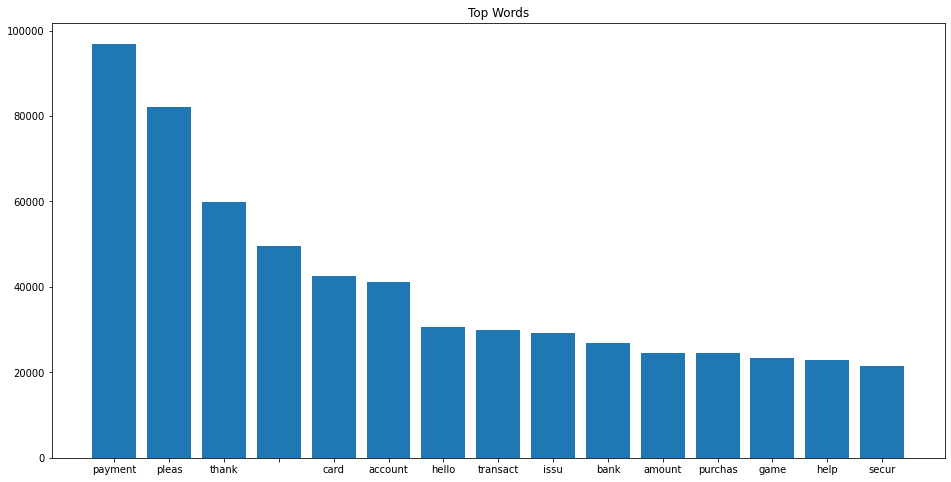

In [20]:
#отлично видим что наши частовстречающиеся слова однородны
c_text = co.Counter( np.concatenate( df['stem_arr'].tolist(), axis=0 )  )

w =[]
count_w = []


most_freq_words = []

for i in c_text.most_common(15):
    w.append(i[0])
    count_w.append(i[1])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(w)), count_w)
ax.set_xticks(range(len(w)))
ax.set_xticklabels(w)
ax.set_title('Top Words')

In [21]:
#оставим для модели топ  слов
top_words = 1500
final_words = pd.DataFrame.from_dict(dict(c_text) , orient = 'index').sort_values(by = 0 , ascending = False).head(top_words).index.values

f = lambda x: ' '.join([item for item in x if item in final_words])
df['stem_arr'] = df['stem_arr'].apply(f)

In [22]:
df

,stem_arr,category
0,verifi card payment charg post bank sofia hell...,afs
1,hi reason didnt go thru receipt tho kate hello...,other
2,faceit hello pay subscript platform data site ...,afs
3,puedo hacer cash infelizment hablo ire googl t...,afs
4,hi buy bit payment hello address issu pleas wa...,afs
...,...,...
49995,make purchas bank card amount account hello pl...,afs
49996,gmail gmail georg georg georg,afs
49997,hi subscript channel use credit card give erro...,other
49998,file http id gmail file messag,afs


# сделаем теперь векторное представление

In [23]:
texts = df['stem_arr']

vec = TfidfVectorizer(max_features=top_words)
tfidf_mat = vec.fit_transform(texts).toarray()
print(type(tfidf_mat),tfidf_mat.shape)
#на выход получаем матрицу заданной размерности

<class 'numpy.ndarray'> (49499, 1492)


# выравнивание классов

In [24]:
train = pd.DataFrame(tfidf_mat)
train['category'] =  df['category']

target = 'category'
train_columns = list(set(train.columns) - set([target]))

train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,afs
1,0.0,0.0,0.0,0.0,0.0,0.0,0.185563,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,other
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,afs
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.1782,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,afs
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.232333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,afs


In [25]:
train.dropna(inplace = True)

In [26]:
#переводим в инты таргет
labels, levels = pd.factorize(train[target])
train['category_int'] = labels

target = 'category_int'

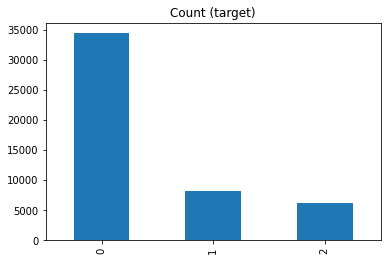

In [27]:
train[target].value_counts().plot(kind='bar', title='Count (target)');

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


rate target detect fight in game 0.0


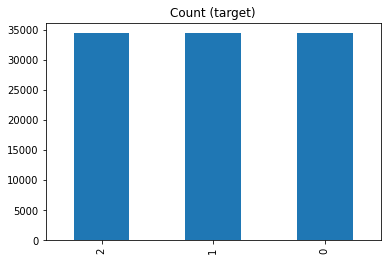

In [29]:
#сделаем оверсемплинг
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(train[train_columns], train[target])

X_ros = pd.DataFrame(X_ros)
y_ros = pd.DataFrame(y_ros)

print(f'rate target detect fight in game {sum(y_ros) / X_ros.shape[0]}')

y_ros[0].value_counts().plot(kind='bar', title='Count (target)');


In [30]:
X_ros[target] = y_ros
train = X_ros[:]

# наконец переходим к модели

In [31]:
#отложим выборку для финальной оценки

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train[train_columns]
                                                    , train[target] 
                                                    , test_size=0.2
                                                    , random_state=42 
                                                    , stratify = train[target] 
                                                   )

print(f'Train set: {x_train.shape[0]} size , {sum(y_train) / x_train.shape[0]} target size')
print(f'Test set: {x_test.shape[0]} size , {sum(y_test) / x_test.shape[0]} target size')


Train set: 82584 size , 1.0 target size
Test set: 20646 size , 1.0 target size


# Сделаем полносвязную сеть на pytorch

In [32]:
import torch
from torch import nn
import torch.nn.functional as F

torch.manual_seed(42) 
np.random.seed(42)
model = nn.Sequential(
    nn.Linear(1492,800),
    nn.ReLU(),
    nn.Dropout(0.8),

    nn.BatchNorm1d(800),
    nn.Linear(800,500),
    nn.ReLU(),
    nn.Dropout(0.8),

    nn.BatchNorm1d(500),
    nn.Linear(500,200),
    nn.ReLU(),
    nn.Dropout(0.8),
    
    nn.BatchNorm1d(200),
    nn.Linear(200,3)
)
    
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#функция тренировки
def train(X_train, y_train, X_test, y_test, num_epoch):
    train_losses = []
    test_losses = []
    for i in range(num_epoch):
        epoch_train_losses = []
        for X_batch, y_batch in batch_generator(X_train, y_train, 500):
            model.train(True)
            y_pred = model(X_batch) 
            
            #print(type(y_pred), type(y_batch))
            loss= loss_fn(y_pred,y_batch)
            
            # зануляем градиент
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.data)    
        train_losses.append(np.nanmean(epoch_train_losses))
        print('trainloss:', np.nanmean(epoch_train_losses))

    return train_losses


# функция-генератор батчей
def batch_generator(X, y, batch_size):
    np.random.seed(42)
    perm = np.random.permutation(len(X))
    for i in range((X.shape[0]//batch_size)+1):
      yield X[perm[i*batch_size:i*batch_size+batch_size],],y[perm[i*batch_size:i*batch_size+batch_size],] 



In [33]:
device=torch.device("cpu")
model = model.to(device)

In [34]:
#переведем все в тензоры
x_train_t = torch.FloatTensor(np.array(x_train)).to(device)
y_train_t = torch.LongTensor(np.array(y_train)).to(device)
x_test_t = torch.FloatTensor(np.array(x_test)).to(device)
y_test_t = torch.LongTensor(np.array(y_test)).to(device)

trainloss: 0.3551353
trainloss: 0.3529774
trainloss: 0.34437886
trainloss: 0.349559
trainloss: 0.34708312
trainloss: 0.34515685
trainloss: 0.34519935
trainloss: 0.34516189
trainloss: 0.34735507
trainloss: 0.3474788
trainloss: 0.347391
trainloss: 0.3477846
trainloss: 0.34555057
trainloss: 0.34615585
trainloss: 0.3442226
trainloss: 0.34425294
trainloss: 0.34354877
trainloss: 0.3443618
trainloss: 0.34338236
trainloss: 0.34499767
trainloss: 0.34260207
trainloss: 0.34144577
trainloss: 0.33905917
trainloss: 0.34501335
trainloss: 0.34104657
trainloss: 0.34310815
trainloss: 0.34089652
trainloss: 0.33961037
trainloss: 0.34173864
trainloss: 0.33434558
trainloss: 0.33816534
trainloss: 0.33858776
trainloss: 0.33690464
trainloss: 0.3375685
trainloss: 0.33615845
trainloss: 0.33864203
trainloss: 0.33795643
trainloss: 0.33582872
trainloss: 0.33653194
trainloss: 0.338636
trainloss: 0.33447123
trainloss: 0.33362418
trainloss: 0.33299834
trainloss: 0.33380634
trainloss: 0.3357159
trainloss: 0.3342045
tra

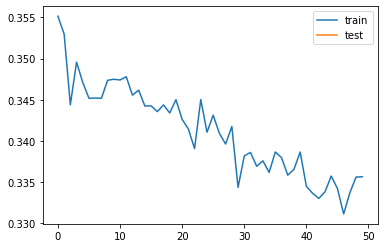

In [ ]:
#запустим обучение
train_losses = train(x_train_t,y_train_t, x_test_t, y_test_t, 50) #Подберите количество эпох так, чтобы график loss сходился
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.legend()
plt.show()

300 эпох спустя

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
model.eval()
predd = model.forward(x_test_t).max(1)[1]
print(classification_report(y_test,predd))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      6882
           1       0.75      0.97      0.85      6882
           2       0.95      0.83      0.89      6882

    accuracy                           0.86     20646
   macro avg       0.88      0.86      0.86     20646
weighted avg       0.88      0.86      0.86     20646



Сохраним модели

In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/Xsolla/nets/weights_86acc.pt")
import pickle
pickle.dump(vec, open("/content/drive/My Drive/Xsolla/nets/mytfidf.pickle", "wb"))

In [ ]:
model.load_state_dict(torch.load("/content/drive/My Drive/Xsolla/nets/weights_86.pt"))

<All keys matched successfully>